In [1109]:
import pandas as pd
from sas7bdat import SAS7BDAT
import statsmodels.formula.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import string
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [ ]:
#Data and description of variables can be downloaded from http://opr.princeton.edu/Archive/NLSF/. We are unable to
#provide a copy of the data set due to an agreement we signed. However, the data set is free and available to anyone; you
#just have to register and sign the agreement in the link above.

In [3022]:
#load pre freshmen survey responses
pre_frosh = SAS7BDAT('~/wave_freshmen.sas7bdat')

In [3023]:
#load freshmen spring survey responses
frosh_spring = SAS7BDAT('~/wave_freshmen_spring.sas7bdat')

In [3024]:
#load sophomore spring survey responses
soph = SAS7BDAT('~/wave_soph.sas7bdat')

In [2838]:
#load junior spring survey responses
junior = SAS7BDAT('~/wave_junior.sas7bdat')

In [2839]:
#load senior spring survey responses
grad = SAS7BDAT('~/wave_grad.sas7bdat')

In [2840]:
#load supplemental survey questions
sup_info = SAS7BDAT('~/freshmen_supp_1.sas7bdat')

In [2841]:
#convert to Pandas data frames
sup_info = sup_info.to_data_frame()
pre_frosh = pre_frosh.to_data_frame()
frosh = frosh_spring.to_data_frame()
soph = soph.to_data_frame()
junior = junior.to_data_frame()
grad = grad.to_data_frame()

In [2842]:
#rename columns so they are all lowercase
pre_frosh.columns = [col.lower() for col in pre_frosh.columns]
frosh.columns = [col.lower() for col in frosh.columns]
soph.columns = [col.lower() for col in soph.columns]
junior.columns = [col.lower() for col in junior.columns]
grad.columns = [col.lower() for col in grad.columns]
sup_info.columns = [col.lower() for col in sup_info.columns]

In [2843]:
#select variables we want from the supplemental dataset
#variable definitions can be found in the PDF's downloaded from the site listed above
sup_cols = ['caseid', 'whit0102', 'blac0102', 'hisp0102', 'asia0102', 'camp0102', 'smal0102', 'med0102', 'larg0102', 
           'tuit0102', 'room0102', 'app0102', 'need0102', 'aid0102', 'grnt0102', 'amt0102', 'debt0102', 'inde0102']
sup_info = sup_info[sup_cols]

In [2844]:
#rename the variables to more readable names
sup_info = sup_info.rename(columns = {'white0102':'pct_white', 'blac0102':'pct_black', 'hisp0102':'pct_hisp', 
                                      'asia0102':'pct_asia', 'camp0102':'on_campus', 'smal0102':'small_class', 
                                      'med0102':'med_class', 'larg0102':'large_class', 'tuit0102':'tuition', 
                                      'room0102':'room', 'app0102':'pct_apply_finaid', 
                                      'need0102':'pct_need_aid', 'aid0102':'pct_need_met', 
                                      'grnt0102':'pct_rec_grants', 'amt0102':'avg_grant', 'debt0102':'pct_w_debt', 
                                      'inde0102':'avg_debt'})

In [2845]:
#select variables from pre freshmen year
pre_frosh_cols = ['caseid', 'college', 'sex', 'w1qzeth', 'fborn', 'hsizelyr', 'lforclyr', 'parntlyr', 'depndlyr', 
       'ysiblyr', 'osiblyr', 'schoolyr', 'w1q38', 'w1q39a', 'w1q62a', 'w1q62b', 'w1q62c', 'w1q62d', 'w1q62e', 'w1q62f',
       'w1q62g', 'w1q62h', 'w1q62i', 'w1q62j', 'w1q173', 'w1q177', 'w1q179', 'w1q180', 'w1q181']
df_pre = pre_frosh[pre_frosh_cols]

In [2846]:
#rename pre freshmen year variables
df_pre = df_pre.rename(columns = {'w1qzeth': 'ethnicity', 'fborn':'us_born', 'parntlyr':'parents_in_house', 
                                 'schoolyr':'mem_in_school', 'w1q38':'hs_type', 'w1q39a':'sports', 'w1q173':'religion',
                                 'w1q177':'home_ownership', 'w1q179':'household_income', 'w1q180':'public_assistance',
                                 'w1q181':'apply_finaid'})

In [2847]:
#select variables indicating how many ap tests student passed, create variable indicating whether or not they passed
ap_cols = ['w1q62a', 'w1q62b', 'w1q62c', 'w1q62d', 'w1q62e', 'w1q62f',
       'w1q62g', 'w1q62h', 'w1q62i', 'w1q62j']

for ap in ap_cols:
    df_pre.loc[~(df_pre[ap].isnull()), ap] = 1
    df_pre[ap] = df_pre[ap].fillna(0)
    

In [2848]:
#sum the number of ap tests passed
df_pre['ap_tests'] = (df_pre.w1q62a + df_pre.w1q62b + df_pre.w1q62c +df_pre.w1q62d+df_pre.w1q62e+df_pre.w1q62f+
                      df_pre.w1q62g + df_pre.w1q62h + df_pre.w1q62i + df_pre.w1q62j)

In [2849]:
df_pre = df_pre.drop(ap_cols, axis = 1)

In [2850]:
#clean variables and rename entries based on variable definition PDF
df_pre['college'] = df_pre.college.map({1:'Liberal Arts', 2:'Private Research', 3:'Public Research'})
df_pre['us_born'] = df_pre.us_born.map({1:'Y', 2:'N', 996:'N', 998: 'N', 997: 'N'})
df_pre['hs_type'] = df_pre.hs_type.map({'01':'Public', '02':'Private Religious', '03':'Private Non Religious', 
                                        '04': 'Home School', '08': 'Seminary', '98': 'Other', '99': 'Other'})
df_pre['sports'] = df_pre.sports.map({1:1, 2:2, 3:3, 4:4, 5:5, 8:1, 7:1})
df_pre['religion'] = df_pre.religion.map({'01':'Catholic', '02':'Protestant', '03':'Jew', 
                                        '04': 'Muslim', '05': 'Hindu', '06': 'Buddhist', '07': 'Greek Orthodox', '08':'Protestant +',
                                         '09':'Jainism', '10':'Unitarian', '11':'Jehovah', '12':'Other', '13':'Other', 
                                         '14':'Other', '77': 'Other', '94':'Other', '95':'None', '96':'Agnostic', '98':'Other',
                                         '97':'Other'})
df_pre['home_ownership'] = df_pre.home_ownership.map({1:'Y', 5:'N', 8:'U', 7:'U'})
df_pre['household_income'] = df_pre.household_income.map({1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11,
                                                         12:12, 13:13, 14:14})
df_pre['household_income'] = df_pre.household_income.fillna(df_pre.household_income.mean())
df_pre['public_assistance'] = df_pre.public_assistance.map({1:'Y', 5:'N', 8:'U', 7:'U'})
df_pre['apply_finaid'] = df_pre.apply_finaid.map({1:'Y', 5:'N', 8:'U', 7:'U'})



In [2851]:
#create dummy variables for categorical variables
cat_vars = [
 u'college',
 u'sex',
 'ethnicity',
 'us_born',
 'hs_type',
 'religion',
 'home_ownership',
 'public_assistance',
 'apply_finaid']
topCatsNum = 10
for var in cat_vars:
    top = df_pre[var].value_counts()[:topCatsNum].index
    df_pre[var].fillna('missing', inplace=True)
    df_pre.loc[~df_pre[var].isin(top), var] = 'other'
    dummies = pd.get_dummies(df_pre[var], prefix=var)
    dummies.columns = [col.replace(' ', '_') for col in dummies.columns]
    df_pre = pd.concat([df_pre,dummies],axis=1)
    del df_pre[var]

In [2852]:
#fill missing values of continuous variables with the mean
df_pre.loc[df_pre.hsizelyr.isnull(), 'hsizelyr'] = df_pre.hsizelyr.mean()
df_pre.loc[df_pre.lforclyr.isnull(), 'lforclyr'] = df_pre.lforclyr.mean()
df_pre.loc[df_pre.parents_in_house.isnull(), 'parents_in_house'] = df_pre.parents_in_house.mean()
df_pre.loc[df_pre.depndlyr.isnull(), 'depndlyr'] = df_pre.depndlyr.mean()
df_pre.loc[df_pre.ysiblyr.isnull(), 'ysiblyr'] = df_pre.ysiblyr.mean()
df_pre.loc[df_pre.osiblyr.isnull(), 'osiblyr'] = df_pre.osiblyr.mean()
df_pre.loc[df_pre.mem_in_school.isnull(), 'mem_in_school'] = df_pre.mem_in_school.mean()
#fill missing sports variable with 1: student did not participate in many sports in HS
df_pre.loc[df_pre.sports.isnull(), 'sports'] = 1

In [2853]:
#convert object types to numeric and fill missing values of categorical variables with 0
dtypeDict = df_pre.dtypes.to_dict()
for col in dtypeDict:
    if dtypeDict[col] == 'object':
        df_pre[col] = df_pre[col].convert_objects(convert_numeric=True).fillna(0)

In [2854]:
#merge pre freshmen and supplemental data
df_pre = pd.merge(df_pre, sup_info, left_on = 'caseid', right_on = 'caseid', how = 'left', copy = False)

In [2917]:
#merge data from all 4 years
df2 = pd.merge(df_pre, frosh, left_on = 'caseid', right_on = 'caseid', how = 'left', copy = False)
df2 = pd.merge(df2, soph, left_on = 'caseid', right_on = 'caseid', how = 'left', copy = False)
df2 = pd.merge(df2, junior, left_on = 'caseid', right_on = 'caseid', how = 'left', copy = False)
df2 = pd.merge(df2, grad[['caseid', 'overallg', 'gradcode']], left_on = 'caseid', right_on = 'caseid', how = 'left', copy = False)

In [2918]:
#students who left at some point freshman year
frosh_dropout = df2[df2.w4q2.isin([1,2,3,4])].caseid.tolist()
#students who left at some point soph year
soph_dropout = df2[df2.w4q2.isin([5,6,7])].caseid.tolist()
#students who left at some point junior year
junior_dropout = df2[df2.w4q2.isin([8,9,10,11])].caseid.tolist()
#students who still have not graduated in 6 years, no record of them graduating was found, or confirmed dropped out
no_grad = df2[df2.overallg == 0].caseid.tolist()

In [2919]:
#find number of students who left in each year and did not return
yr1 = len(frosh[((frosh.caseid.isin(frosh_dropout)) & (frosh.caseid.isin(no_grad)))])
yr2 = len(soph[((soph.caseid.isin(soph_dropout)) & (soph.caseid.isin(no_grad)))])
yr3 = len(junior[((junior.caseid.isin(junior_dropout)) & (junior.caseid.isin(no_grad)))])

print '# dropouts freshman year:', yr1
print '# dropouts sophomore year:', yr2
print '# dropouts junior year:', yr3


# dropouts freshman year: 9
# dropouts sophomore year: 33
# dropouts junior year: 28


In [2920]:
yr4 = len(no_grad) - yr1 - yr2 - yr3
print '# dropouts senior year and beyond:', yr4

# dropouts senior year and beyond: 457


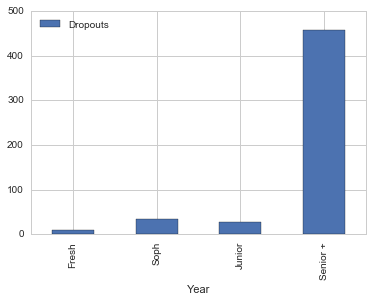

In [2921]:
#plot dropout per year
d = {'Year':['Fresh', 'Soph', 'Junior', 'Senior +'], 'Dropouts':[yr1, yr2, yr3, yr4]}
df_dropout = pd.DataFrame(d)
df_dropout.plot(kind='bar', x = 'Year', y = 'Dropouts')

In [2922]:
#remove students who dropped out freshmen or sophomore year
df2 = df2[~((df2.caseid.isin(soph_dropout)) & (df2.caseid.isin(no_grad)))]
df2 = df2[~((df2.caseid.isin(frosh_dropout)) & (df2.caseid.isin(no_grad)))]

In [2923]:
#find number of courses student registered in fall and spring and rename columns
df2['w2q4'] = df2.w2q4.fillna(0)
df2['w3q8'] = df2.w3q8.fillna(0)
df2['w3q12'] = df2.w3q12.fillna(0)
df2['w3q14'] = df2.w3q16.fillna(0)

df2 = df2.rename(columns = {'w2q4':'courses_reg_f_fall', 'w3q8':'courses_reg_f_spring', 'w3q12':'courses_reg_s_fall',
                           'w3q14':'courses_reg_s_spring'})

In [2924]:
#create variable of whether or not student missed semesters based on if they registered for 0 classes
df2['out_f_fall'] = 0
df2.loc[df2.courses_reg_f_fall == 0, 'out_f_fall'] = 1

df2['out_f_spring'] = 0
df2.loc[df2.courses_reg_f_spring == 0, 'out_f_spring'] = 1

df2['out_s_fall'] = 0
df2.loc[df2.courses_reg_s_fall == 0, 'out_s_fall'] = 1

df2['out_s_spring'] = 0
df2.loc[df2.courses_reg_s_spring == 0, 'out_s_spring'] = 1

In [2925]:
#sum missed semesters in first two years
df2['missed_sems'] = df2[['out_f_fall', 'out_f_spring', 'out_s_fall', 'out_s_spring']].sum(axis = 1)

In [2927]:
#processing and cleaning variables for which classes student completed
classes = []

for i in range(10):
    alpha = string.ascii_lowercase
    col = 'w2q5d' + alpha[i]
    classes.append(col)
    
    alpha = string.ascii_lowercase
    col = 'w3q9' + alpha[i] + '4'
    classes.append(col)
    
    alpha = string.ascii_lowercase
    col = 'w3q13' + alpha[i] + '4'
    classes.append(col)
    
    alpha = string.ascii_lowercase
    col = 'w3q17' + alpha[i] + '4'
    classes.append(col) 

for item in classes:
    df2[item] = df2[item].map({1:1, 2:1, 3:0, 8:0, 7:0})  

In [2928]:
#create variable for classes completed, classes registered, classes dropped, and percentage of classes ropped
df2['classes_completed'] = df2[classes].sum(axis = 1)
df2['classes_registered'] = df2[['courses_reg_f_fall', 'courses_reg_f_spring', 'courses_reg_s_fall', 'courses_reg_s_spring']].sum(axis = 1)
df2['dropped_classes'] = df2.classes_registered - df2.classes_completed
df2['pct_classes_dropped'] = df2.dropped_classes / df2.classes_registered

In [2929]:
#remove students who didn't complete any classes in first two years. These students resumed/started their classes in 
#second two years so not relevant for this analysis
df2 = df2[~((df2.classes_registered == 0) | (df2.classes_completed == 0))]

In [2930]:
#preprocessing and cleaning grades variables
grades = []

for i in range(10):
    alpha = string.ascii_lowercase
    col = 'w2q5e' + alpha[i]
    grades.append(col)
    
    alpha = string.ascii_lowercase
    col = 'w3q9' + alpha[i] + '5'
    grades.append(col)
    
    alpha = string.ascii_lowercase
    col = 'w3q13' + alpha[i] + '5'
    grades.append(col)
    
    alpha = string.ascii_lowercase
    col = 'w3q17' + alpha[i] + '5'
    grades.append(col) 
#code equivlent GPA scores
for item in grades:
    df2[item] = df2[item].map({1:4, 2:3.7, 3:3.3, 4:3, 5:2.7, 6:2.3, 7:2, 8:1.7, 9:1.3, 10:1, 11:0.7, 
                                            12:0, 13:0, 14:2, 15:0, 16:2, 17:2, 18:0, 995:2, 777:0, 998:0, 997:0, 999:0})
    df2[item] = df2[item].fillna(0)

In [2931]:
#calculate GPA
df2['gpa'] = df2[grades].sum(axis = 1) / df2['classes_completed']

In [2932]:
#add indicator of whether student dropped out after sophomore year
df2['drop_out'] = 0
df2.loc[df2.caseid.isin(no_grad), 'drop_out'] = 1

In [2933]:
#rename freshman financial variables
df2 = df2.rename(columns = {'w2q25':'f_college_cost_est', 'w2q26a':'f_parent_contribution', 'w2q26b':'f_fam_contribution',
                           'w2q26c':'f_uni_grant', 'w2q26d':'f_other_grant', 'w2q26e':'f_student_loan', 'w2q26f':'f_savings',
                           'w2q26g':'f_work_study', 'w2q26h':'f_other_work', 'w2q26i':'f_other_funds', 'w2q26j':'f_credit_card',
                           'w2q27':'f_have_job', 'w2q28b':'f_work_hrs_week', 'w2q28c':'f_wage', 'w2q28e':'f_finaid_work'})

In [2934]:
#fill null responses with median
df2.loc[(df2.f_college_cost_est.isin([999998, 999997])) | (df2.f_college_cost_est.isnull()), 
        'f_college_cost_est'] = df2.f_college_cost_est.median()
df2.loc[(df2.f_parent_contribution.isin([999998, 999997])) | (df2.f_parent_contribution.isnull()), 
        'f_parent_contribution'] = df2.f_parent_contribution.median()
df2.loc[(df2.f_fam_contribution.isin([999998, 999997])) | (df2.f_fam_contribution.isnull()), 
        'f_fam_contribution'] = df2.f_fam_contribution.median()
df2.loc[(df2.f_uni_grant.isin([999998, 999997])) | (df2.f_uni_grant.isnull()), 
        'f_uni_grant'] = df2.f_uni_grant.median()
df2.loc[(df2.f_other_grant.isin([999998, 999997])) | (df2.f_other_grant.isnull()), 
        'f_other_grant'] = df2.f_other_grant.median()
df2.loc[(df2.f_student_loan.isin([999998, 999997])) | (df2.f_student_loan.isnull()), 
        'f_student_loan'] = df2.f_student_loan.median()
df2.loc[(df2.f_savings.isin([999998, 999997])) | (df2.f_savings.isnull()), 
        'f_savings'] = df2.f_savings.median()
df2.loc[(df2.f_work_study.isin([999998, 999997])) | (df2.f_work_study.isnull()), 
        'f_work_study'] = df2.f_work_study.median()
df2.loc[(df2.f_other_work.isin([999998, 999997])) | (df2.f_other_work.isnull()), 
        'f_other_work'] = df2.f_other_work.median()
df2.loc[(df2.f_other_funds.isin([999998, 999997])) | (df2.f_other_funds.isnull()), 
        'f_other_funds'] = df2.f_other_funds.median()

In [2935]:
#clean freshman financial data more
df2.loc[df2.f_credit_card != 1, 'f_credit_card'] = 0
df2.loc[df2.f_have_job != 1, 'f_have_job'] = 0
df2.loc[(df2.f_work_hrs_week == 98) | (df2.f_work_hrs_week == 97), 'f_work_hrs_week'] = df2.f_work_hrs_week.median()
df2['f_work_hrs_week'] = df2.f_work_hrs_week.fillna(0)

df2.loc[(df2.f_wage == 998) | (df2.f_wage == 997), 'f_wage'] = df2.f_wage.median()
df2['f_wage'] = df2.f_wage.fillna(0)

df2.loc[df2.f_finaid_work != 1, 'f_finaid_work'] = 0

In [2936]:
#calculate total contributions toward college expenses outside of jobs. Focus on money that don't conflict with time in 
#classes/academics
df2['f_total_contribution'] = df2[['f_parent_contribution', 'f_fam_contribution', 'f_uni_grant', 'f_other_grant', 
                                  'f_student_loan', 'f_savings']].sum(axis = 1)

In [2937]:
import numpy as np

In [2938]:
#calculate freshmen cost gap and funding gap
df2['f_cost_gap'] = df2.f_college_cost_est - df2.f_total_contribution
df2['f_gap_pct'] = df2.f_cost_gap / df2.f_college_cost_est
df2.loc[df2.f_gap_pct == -np.inf, 'f_gap_pct'] = 0

In [2939]:
#calculate total grants received freshman year
df2['f_total_grants'] = df2.f_uni_grant + df2.f_other_grant

In [2940]:
#repeat above for sophomore year
df2 = df2.rename(columns = {'w3q52':'s_college_cost_est', 'w3q53a':'s_parent_contribution', 'w3q53b':'s_fam_contribution',
                           'w3q53c':'s_uni_grant', 'w3q53d':'s_other_grant', 'w3q53e':'s_student_loan', 'w3q53f':'s_savings',
                           'w3q53g':'s_work_study', 'w3q53h':'s_other_work', 'w3q53i':'s_other_funds', 'w3q53j':'s_credit_card',
                           'w3q54':'s_have_job', 'w3q54b':'s_work_hrs_week', 'w3q52c':'s_wage', 'w3q54d':'s_finaid_work'})

In [2941]:
df2.loc[(df2.s_college_cost_est.isin([999998, 999997])) | (df2.s_college_cost_est.isnull()), 
        's_college_cost_est'] = df2.s_college_cost_est.median()
df2.loc[(df2.s_parent_contribution.isin([999998, 999997])) | (df2.s_parent_contribution.isnull()), 
        's_parent_contribution'] = df2.s_parent_contribution.median()
df2.loc[(df2.s_fam_contribution.isin([999998, 999997])) | (df2.s_fam_contribution.isnull()), 
        's_fam_contribution'] = df2.s_fam_contribution.median()
df2.loc[(df2.s_uni_grant.isin([999998, 999997])) | (df2.s_uni_grant.isnull()), 
        's_uni_grant'] = df2.s_uni_grant.median()
df2.loc[(df2.s_other_grant.isin([999998, 999997])) | (df2.s_other_grant.isnull()), 
        's_other_grant'] = df2.s_other_grant.median()
df2.loc[(df2.s_student_loan.isin([999998, 999997])) | (df2.s_student_loan.isnull()), 
        's_student_loan'] = df2.s_student_loan.median()
df2.loc[(df2.s_savings.isin([999998, 999997])) | (df2.s_savings.isnull()), 
        's_savings'] = df2.s_savings.median()
df2.loc[(df2.s_work_study.isin([999998, 999997])) | (df2.s_work_study.isnull()), 
        'f_work_study'] = df2.f_work_study.median()
df2.loc[(df2.s_other_work.isin([999998, 999997])) | (df2.s_other_work.isnull()), 
        's_other_work'] = df2.s_other_work.median()
df2.loc[(df2.s_other_funds.isin([999998, 999997])) | (df2.s_other_funds.isnull()), 
        's_other_funds'] = df2.s_other_funds.median()

In [2942]:
df2.loc[df2.s_credit_card != 1, 's_credit_card'] = 0
df2.loc[df2.s_have_job != 1, 's_have_job'] = 0
df2.loc[(df2.s_work_hrs_week == 98) | (df2.s_work_hrs_week == 97), 's_work_hrs_week'] = df2.s_work_hrs_week.median()
df2['s_work_hrs_week'] = df2.s_work_hrs_week.fillna(0)

df2.loc[(df2.s_wage == 998) | (df2.s_wage == 997), 's_wage'] = df2.s_wage.median()
df2['s_wage'] = df2.s_wage.fillna(0)

df2.loc[df2.s_finaid_work != 1, 's_finaid_work'] = 0

In [2943]:
df2['s_total_contribution'] = df2[['s_parent_contribution', 's_fam_contribution', 's_uni_grant', 's_other_grant', 
                                  's_student_loan', 's_savings']].sum(axis = 1)

In [2944]:
df2['s_cost_gap'] = df2.s_college_cost_est - df2.s_total_contribution
df2['s_gap_pct'] = df2.s_cost_gap / df2.s_college_cost_est
df2.loc[df2.s_gap_pct == -np.inf, 's_gap_pct'] = 0

In [2945]:
df2['s_total_grants'] = df2.s_uni_grant + df2.s_other_grant

In [2946]:
#rename variables for whether parents went to college
df2 = df2.rename(columns = {'w3q79':'mom_college', 'w3q81':'dad_college'})

In [2947]:
df2.loc[df2.mom_college != 1, 'mom_college'] = 0
df2.loc[df2.dad_college != 1, 'dad_college'] = 0

In [2948]:
###add interference variables and sum: distractions from outside of school
df2 = df2.rename(columns = {'w2q24a':'f_parents_moved', 'w2q24b':'f_parent_married', 'w2q24c':'f_parents_div', 
                           'w2q24d':'f_parent_lost_job', 'w2qq24d':'f_which_parent_lost_job', 'w2q24f':'f_ill', 
                           'w2q24g':'f_sis_preg', 'w2q24h':'f_sib_dropout', 'w2q24i':'f_parent_on_pa', 
                            'w2q24j':'f_fam_on_pa', 'w2q24k':'f_fam_on_drugs', 'w2q24l':'f_fam_rehab', 
                            'w2q24m':'f_fam_crime_victim', 'w2q24n':'f_fam_arrested', 'w2q24o':'f_fam_ill', 
                           'w2q24p':'f_fam_homeless', 'w2q24q':'f_parent_died', 'w2qq24q':'f_which_parent_died',
                           'w2q24r':'f_relative_die'})

In [2949]:
f_interference = ['f_parents_div', 
                           'f_parent_lost_job','f_ill', 
                           'f_sis_preg', 'f_sib_dropout', 'f_parent_on_pa', 
                            'f_fam_on_pa', 'f_fam_on_drugs', 'f_fam_rehab', 
                            'f_fam_crime_victim', 'f_fam_arrested', 'f_fam_ill', 
                           'f_fam_homeless', 'f_parent_died',
                           'f_relative_die']

In [2950]:
for item in f_interference:
    df2.loc[(df2[item].isin([5,8])) | (df2[item].isnull()), item] = 0
    df2.loc[(df2[item] == 7), item] = 1

df2.loc[df2.f_which_parent_lost_job == 3, 'f_parent_lost_job'] = 2
df2.loc[df2.f_which_parent_died == 3, 'f_parent_died'] = 2

In [2951]:
#sum total interference student experienced
df2['f_total_interference'] = df2[f_interference].sum(axis = 1)

In [2952]:
df2 = df2.rename(columns = {'w3q51a':'s_parents_moved', 'w3q51b':'s_parent_married', 'w3q51c':'s_parents_div', 
                           'w3q51d':'s_parent_lost_job', 'w3q51dx':'s_which_parent_lost_job', 'w3q51f':'s_ill', 
                           'w3q51g':'s_sis_preg', 'w3q51h':'s_sib_dropout', 
                            'w3q51i':'s_fam_on_pa', 'w3q51j':'s_fam_on_drugs', 'w3q51k':'s_fam_rehab', 
                            'w3q51l':'s_fam_crime_victim', 'w3q51m':'s_fam_arrested', 'w3q51n':'s_fam_ill', 
                           'w3q51o':'s_fam_homeless', 'w3q51p':'s_parent_died', 'w3q51px':'s_which_parent_died',
                           'w3q51q':'s_relative_die', 'w3q51r':'s_extended_fam_die', 'w3q51s': 's_friend_die'})

In [2953]:
s_interference = ['s_parents_div', 
                           's_parent_lost_job', 's_which_parent_lost_job', 's_ill', 
                           's_sis_preg', 's_sib_dropout', 
                            's_fam_on_pa', 's_fam_on_drugs', 's_fam_rehab', 
                            's_fam_crime_victim', 's_fam_arrested', 's_fam_ill', 
                           's_fam_homeless', 's_parent_died', 's_which_parent_died',
                           's_relative_die', 's_extended_fam_die', 's_friend_die']

In [2954]:
for item in s_interference:
    df2.loc[(df2[item].isin([5,8])) | (df2[item].isnull()), item] = 0
    df2.loc[(df2[item] == 7), item] = 1

df2.loc[df2.s_which_parent_lost_job == 3, 's_parent_lost_job'] = 2
df2.loc[df2.s_which_parent_died == 3, 's_parent_died'] = 2

In [2955]:
#sum total interference student experienced
df2['s_total_interference'] = df2[s_interference].sum(axis = 1)

In [2956]:
#household income at end of sophomore year
df2 = df2.rename(columns = {'w3q86': 's_household_income'})

In [2957]:
df2['s_household_income'] = df2.s_household_income.map({1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11})
df2['s_household_income'] = df2.s_household_income.fillna(df2.s_household_income.mean())

In [2958]:
##cleaning perceptions of prejudice variables
f_prejudice = []
for num in range(39, 51):
    question = 'w2q' + str(num)
    f_prejudice.append(question)

In [2959]:
for item in f_prejudice:
    df2.loc[df2[item].isin([8]), item] = 0
    df2.loc[df2[item] == 7, item] = 5
    df2[item] = df2[item].fillna(0)

In [2960]:
s_prejudice = []
for num in range(60, 72):
    question = 'w3q' + str(num)
    s_prejudice.append(question)

In [2961]:
for item in s_prejudice:
    df2.loc[df2[item].isin([8]), item] = 0
    df2.loc[df2[item] == 7, item] = 5
    df2[item] = df2[item].fillna(0)

In [2962]:
df2['prejudice_score'] = df2[f_prejudice + s_prejudice].sum(axis = 1)

In [2963]:
#cleaning mental state variables
df2 = df2.rename(columns = {'w2q32a':'f_not_doing_well', 'w2q32b':'f_problems_finaid', 'w2q34':'f_effort', 
                            'w3q44a':'s_not_doing_well', 'w3q44b':'s_problems_finaid', 'w3q45':'s_effort'})

In [2964]:
df2.loc[(df2.f_not_doing_well.isin([98, 97])) | (df2.f_not_doing_well.isnull()), 'f_not_doing_well'] = df2.f_not_doing_well.mean()
df2.loc[(df2.s_not_doing_well.isin([98, 97])) | (df2.s_not_doing_well.isnull()), 's_not_doing_well'] = df2.s_not_doing_well.mean()
df2['not_doing_well_score'] = df2.f_not_doing_well + df2.s_not_doing_well

df2.loc[(df2.f_problems_finaid.isin([98, 97])) | (df2.f_problems_finaid.isnull()), 'f_problems_finaid'] = df2.f_problems_finaid.mean()
df2.loc[(df2.s_problems_finaid.isin([98, 97])) | (df2.s_problems_finaid.isnull()), 's_problems_finaid'] = df2.s_problems_finaid.mean()
df2['problems_finaid_score'] = df2.f_problems_finaid + df2.s_problems_finaid

df2.loc[(df2.f_effort.isin([98, 97])) | (df2.f_effort.isnull()), 'f_effort'] = df2.f_effort.mean()
df2.loc[(df2.s_effort.isin([98, 97])) | (df2.s_effort.isnull()), 's_effort'] = df2.s_effort.mean()
df2['effort_score'] = df2.f_effort + df2.s_effort

In [2965]:
#sleep and studying per week variables
df2 = df2.rename(columns = {'w2q21b':'f_hours_studying', 'w2q21c':'f_hours_extracurricular',
                           'w3q40b':'s_hours_studying', 'w3q40k':'s_hours_extracurricular', 'w3q40l':'s_hours_sleeping'})

In [2966]:
edits = ['f_hours_studying', 'f_hours_extracurricular',
                           's_hours_studying', 's_hours_extracurricular', 's_hours_sleeping']
for item in edits:
    df2.loc[(df2[item].isin([998,997])) | (df2[item].isnull()), item] = df2[item].mean()

In [2967]:
df2['avg_hrs_studying'] = (df2.f_hours_studying + df2.s_hours_studying)/2
df2['avg_hrs_extracurricular'] = (df2.f_hours_extracurricular + df2.s_hours_extracurricular)/2

In [2968]:
#lonely and homesick, wanna get away from campus variables
df2 = df2.rename(columns = {'w2q16h':'f_lonely', 'w3q35h':'s_lonely', 'w2q16i':'f_get_away_campus', 'w3q35i':'s_get_away_campus'})

In [2969]:
edit = ['f_lonely', 's_lonely', 'f_get_away_campus', 's_get_away_campus']
for item in edit:
    df2.loc[df2[item] == 98, item] = 0
    df2.loc[(df2[item] == 97) | (df2[item].isnull()), item] = df2[item].mean()

In [2970]:
df2['lonely_score'] = df2.f_lonely + df2.s_lonely
df2['get_away_from_campus_score'] = df2.f_get_away_campus + df2.s_get_away_campus

In [2971]:
#select columns to be 
cols = df_pre.columns.tolist() + (['gpa', 'classes_completed', 'pct_classes_dropped', 'dropped_classes', 'classes_registered', 
                                 'missed_sems', 'drop_out', 'f_college_cost_est', 'f_total_contribution', 'f_cost_gap',
                                 'f_gap_pct', 'f_parent_contribution', 'f_fam_contribution', 'f_total_grants', 'f_student_loan',
                                 'f_credit_card', 'f_have_job', 'f_work_hrs_week', 'f_wage', 'f_finaid_work'] +
                                  ['s_college_cost_est', 's_total_contribution', 's_cost_gap',
                                 's_gap_pct', 's_parent_contribution', 's_fam_contribution', 's_total_grants', 's_student_loan',
                                 's_credit_card', 's_have_job', 's_work_hrs_week', 's_wage', 's_finaid_work'] +
                                 ['mom_college', 'dad_college'] + f_interference + ['f_total_interference'] + s_interference+
                                 ['s_total_interference', 's_household_income', 'prejudice_score', 'lonely_score', 
                                 'get_away_from_campus_score', 'effort_score', 'problems_finaid_score', 'not_doing_well_score',
                                 'avg_hrs_studying', 'avg_hrs_extracurricular', 's_hours_sleeping']) 

In [2972]:
#use data frame of just test columns
df3 = df2[cols]

In [2973]:
len(df3)

3745

In [2974]:
#create aggregate variables for first two years
df3['total_college_cost'] = df3[['f_college_cost_est', 's_college_cost_est']].sum(axis = 1)
df3['total_contribution'] = df3[['f_total_contribution', 's_total_contribution']].sum(axis = 1)
df3['total_cost_gap'] = df3[['s_cost_gap', 'f_cost_gap']].sum(axis = 1)
df3['total_gap_pct'] = df3.total_cost_gap / df3.total_college_cost
df3['total_parent_contribution'] = df3[['f_parent_contribution', 's_parent_contribution']].sum(axis = 1)
df3['total_fam_contribution'] = df3.f_fam_contribution + df3.s_fam_contribution
df3['total_grants'] = df3.f_total_grants + df3.s_total_grants
df3['total_student_loan'] = df3.f_student_loan + df3.s_student_loan
df3['total_interference'] = df3.f_total_interference + df3.s_total_interference

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [2981]:
df3[df3.total_cost_gap >= 20000].drop_out.value_counts()

0    354
1    111
Name: drop_out, dtype: int64

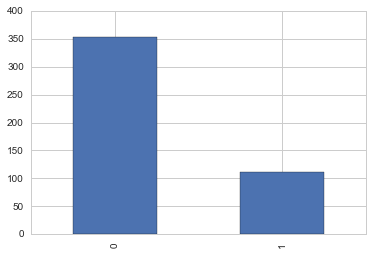

In [2980]:
#examine students with funding gap of over 20000 dollars and how many drop out
# 0 = didn't drop out, 1 = dropout
df3[df3.total_cost_gap >= 20000].drop_out.value_counts().plot(kind = 'bar')

In [2982]:
#subset data to only students of funding gap greater than or equal to 20000
df3 = df3[df3.total_cost_gap >= 20000]

In [2984]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

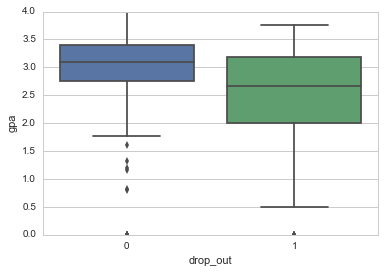

In [2988]:
#see that GPA is important in determining who drops out
ax = sns.boxplot(x="drop_out", y="gpa", data=df3)
plt.show()

In [2997]:
#select only aggregate variables for regression
topCols = ['gpa','classes_completed', 'pct_classes_dropped', 'total_parent_contribution', 'total_college_cost', 
          'total_contribution', 's_work_hrs_week', 'total_gap_pct', 'missed_sems', 'ap_tests', 'total_grants', 
          'pct_apply_finaid', 'total_cost_gap', 'lforclyr', 'total_student_loan', 'hsizelyr', 'total_interference',
          'household_income', 'mem_in_school', 'pct_w_debt', 'large_class', 'room', 'avg_debt', 'pct_need_met',
          'tuition', 'pct_need_aid', 'med_class', 'small_class', 'total_fam_contribution', 'on_campus', 'pct_rec_grants',
          'avg_grant', 'ysiblyr', 'osiblyr', 'pct_black', 'dropped_classes', 'depndlyr', 'ethnicity_B', 'pct_hisp',
          'sex_F', 'hs_type_Public', 'hs_type_Private_Religious', 'ethnicity_W', 'ethnicity_A', 'mom_college', 'ethnicity_H',
          'apply_finaid_Y', 'public_assistance_Y', 'us_born_Y', 'public_assistance_Y', 'dad_college', 'home_ownership_Y',
          'college_Private_Research', 'hs_type_Private_Non_Religious', 'college_Liberal_Arts', 'hs_type_Home_School', 
          'f_work_hrs_week', 's_household_income', 'prejudice_score', 'get_away_from_campus_score', 'lonely_score', 
          'not_doing_well_score', 'effort_score', 'problems_finaid_score', 's_hours_sleeping', 'avg_hrs_extracurricular',
          'avg_hrs_studying']

In [2998]:
#run preliminary model
rfModel = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=1, max_features=len(topCols),
                              oob_score=True, max_depth=None,random_state=42)
    
rfModel.fit(df3[topCols], df3.drop_out)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=67, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
           verbose=1, warm_start=False)

In [2999]:
results = df3.copy(deep = True)
results['predsRaw'] = rfModel.oob_prediction_
results['Preds'] = results.predsRaw > 0.1
results['Preds'] = results['Preds'].astype(int)
results['correct'] = (results.drop_out == results.Preds)

In [3000]:
print 'Overall accuracy:'
print float(results.correct.sum())/float(len(results))
print 'Percentage of actual dropouts correctly predicted:'
print float(results[results.drop_out == 1].correct.sum()) / float(len(results[results.drop_out == 1]))
print "Percentage of actual dropout apps missed:"
print 1-float(results[results.drop_out == 1].correct.sum()) / float(len(results[results.drop_out == 1]))
print 'Ratio of true positives to false positives:' 
print results[results.Preds == 1].correct.sum(), ":", len(results[(results.Preds == 1) & (results.correct ==0)])

Overall accuracy:
0.464516129032
Percentage of actual dropouts correctly predicted:
0.864864864865
Percentage of actual dropout apps missed:
0.135135135135
Ratio of true positives to false positives:
96 : 234


In [3001]:
temp = rfModel.feature_importances_
imp = pd.DataFrame(topCols,temp)
imp = imp.reset_index()
imp.columns = ['avg_imp', 'feat']
imp = imp.sort_values('avg_imp',ascending=False)

In [3002]:
#variable importances
imp

,avg_imp,feat
0,0.122142,gpa
2,0.054529,pct_classes_dropped
1,0.040338,classes_completed
58,0.039328,prejudice_score
65,0.034994,avg_hrs_extracurricular
12,0.033966,total_cost_gap
3,0.032771,total_parent_contribution
66,0.032627,avg_hrs_studying
62,0.030514,effort_score
11,0.028169,pct_apply_finaid


In [3003]:
#select top 21 variables: we tried various numbers including more and less than 21. 21 was the best
topCols = imp.head(21).feat.values

In [2612]:
rfModel = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=1, max_features=len(topCols),
                              oob_score=True, max_depth=None,random_state=42)
    
rfModel.fit(df3[topCols], df3.drop_out)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=21, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
           verbose=1, warm_start=False)

In [2653]:
import pickle

In [3006]:
predictPath = '~/BridgeEdu Challenge/'

In [3007]:
#open final model we saved
rfModel = pickle.load(open(predictPath + "rfModel.p", "rb"))

In [3008]:
#open final variables we saved
topCols = pickle.load(open(predictPath + "topCols.p", "rb"))

In [3009]:
results = df3.copy(deep = True)
results['predsRaw'] = rfModel.oob_prediction_
results['Preds'] = results.predsRaw > .26
results['Preds'] = results['Preds'].astype(int)
results['correct'] = (results.drop_out == results.Preds)

In [3010]:
print 'Overall accuracy:'
print float(results.correct.sum())/float(len(results))
print 'Percentage of actual dropouts correctly predicted:'
print float(results[results.drop_out == 1].correct.sum()) / float(len(results[results.drop_out == 1]))
print "Percentage of actual dropout apps missed:"
print 1-float(results[results.drop_out == 1].correct.sum()) / float(len(results[results.drop_out == 1]))
print 'Ratio of true positives to false positives:' 
print results[results.Preds == 1].correct.sum(), ":", len(results[(results.Preds == 1) & (results.correct ==0)])

Overall accuracy:
0.72688172043
Percentage of actual dropouts correctly predicted:
0.738738738739
Percentage of actual dropout apps missed:
0.261261261261
Ratio of true positives to false positives:
82 : 98


In [3011]:
#calculate r^2 value
results2 = df3.copy(deep = True)
results2['score'] = rfModel.predict(df3[topCols])

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [3012]:
r_square = results2[['drop_out', 'score']]
r_square['error'] = r_square.drop_out - r_square.score
r_square['something'] = r_square.drop_out - r_square.drop_out.mean()
r_square['numer'] = r_square.error **2
r_square['denom'] = r_square.something **2

In [3016]:
print 'R^2 value for random forest is:', 1 - (r_square.numer.sum() / r_square.denom.sum())

R^2 value for random forest is: 0.881857764544


In [2571]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, cross_val_predict

In [3017]:
#build logistic model using same variables as benchmark
results = df3.copy(deep = True)
results['predsRaw'] = cross_val_predict(LogisticRegression(), df3[topCols], df3.drop_out, cv=10)
results['Preds'] = results.predsRaw > 0.26
results['Preds'] = results['Preds'].astype(int)
results['correct'] = (results.drop_out == results.Preds)

In [3018]:
print 'Overall accuracy:'
print float(results.correct.sum())/float(len(results))
print 'Percentage of actual dropouts correctly predicted:'
print float(results[results.drop_out == 1].correct.sum()) / float(len(results[results.drop_out == 1]))
print "Percentage of actual dropout apps missed:"
print 1-float(results[results.drop_out == 1].correct.sum()) / float(len(results[results.drop_out == 1]))
print 'Ratio of true positives to false positives:' 
print results[results.Preds == 1].correct.sum(), ":", len(results[(results.Preds == 1) & (results.correct ==0)])

Overall accuracy:
0.761290322581
Percentage of actual dropouts correctly predicted:
0.18018018018
Percentage of actual dropout apps missed:
0.81981981982
Ratio of true positives to false positives:
20 : 20


In [3019]:
logit = LogisticRegression()

In [3020]:
logit.fit(df3[topCols], df3.drop_out)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [3021]:
print 'R^2 of logistic model:', logit.score(df3[topCols], df3.drop_out)

R^2 of logistic model: 0.765591397849
